# Car crash report analysis

In [1]:
# Setup, Import/Install required libraries
import requests
from bs4 import BeautifulSoup
import csv
import openpyxl
from openpyxl.cell.cell import ILLEGAL_CHARACTERS_RE
import re
!pip install --upgrade matplotlib
!pip install xlsxwriter
import matplotlib.pyplot as plt
!pip install -q wordcloud
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
import pandas as pd
import io
import unicodedata
import numpy as np
import string
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.chunk import RegexpParser
import seaborn as sns
import folium
from folium import plugins
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# set the URL of the website to be scraped for all troops
url = 'https://www.mshp.dps.missouri.gov/HP68/SearchAction?searchTroop={troop}'

# List of Troops
troops = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 4.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Loop through all troops to collect all data

In [2]:
report_nums = set()

# create a CSV file to store the links
with open('view_links_all_troops.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    for troop in troops:
        response = requests.get(url.format(troop=troop))
        # parse the HTML content of the response using Beautiful Soup
        soup = BeautifulSoup(response.content, 'html.parser')
        report_links = soup.find_all('a', string='View')
        for link in report_links:
            report_num = link['href'].split('=')[-1]
            if report_num not in report_nums:
                report_nums.add(report_num)
                writer.writerow([f'https://www.mshp.dps.missouri.gov/HP68/AccidentDetailsAction?ACC_RPT_NUM={report_num}'])

# *Collecting the Crash Information based on Incident number of all crash reports

In [3]:
with open('view_links_all_troops.csv', newline='') as csvfile:
    urls = [url[0] for url in csv.reader(csvfile)]

workbook = openpyxl.Workbook()

worksheet1 = workbook.active
worksheet1.title = 'Sheet1'
headers1 = ['Investigated By', 'Incident#', 'GPS Latitude', 'GPS Longitude', 'Date', 'Time', 'County', 'Location', 'Troop']
worksheet1.append(headers1)

worksheet2 = workbook.create_sheet(title='Sheet2')
headers2 = ['Incident#', 'Veh. #', 'Vehicle Description', 'Damage', 'Disposition', 'Driver Name', 'Driver Gender', 'Driver Age', 'Safety Device', 'Driver City/State', 'Driver Insurance', 'Vehicle Direction']
worksheet2.append(headers2)

worksheet3 = workbook.create_sheet(title='Sheet3')
headers3 = ['Incident#', 'Veh. #', 'Name', 'Gender', 'Age', 'Injury Type', 'Safety Device', 'City/State', 'Involvement']
worksheet3.append(headers3)

worksheet4 = workbook.create_sheet(title='Sheet4')
headers4 = ['Incident#', 'Misc Information']
worksheet4.append(headers4)

for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    incident_num = url.split('=')[-1]
    table1 = soup.find_all('table')[0]
    rows1 = table1.find_all('tr')[1:]
    for row in rows1:
        data = [td.text.strip() for td in row.find_all('td')]
        worksheet1.append(data)
    table2 = soup.find_all('table')[1]
    rows2 = table2.find_all('tr')[1:]
    for row in rows2:
        data = [td.text.strip() for td in row.find_all('td')]
        worksheet2.append([incident_num] + data)
    table3 = soup.find_all('table')[2]
    rows3 = table3.find_all('tr')[1:]
    for row in rows3:
        data = [td.text.strip() for td in row.find_all('td')[:-1]]  # exclude last column
        worksheet3.append([incident_num] + data)
    table = soup.find_all('table', class_='accidentOutput')[3]
    rows_data = []
    rows = table.find_all('tr')
    for row in rows:
        cells = row.find_all('td')
        row_data = [cell.text.strip() for cell in cells]
        if row_data:
            rows_data.append(row_data)
    for row_data in rows_data:
        worksheet4.append([incident_num] + row_data)
workbook.save('Crash Information.xlsx')


# Analysis of Dataset of Crash Information

# 1.   Upon analysis with the total number of incidents taking place in every hour through heatmap and stackbar, we understand what is the major type of injury taking place

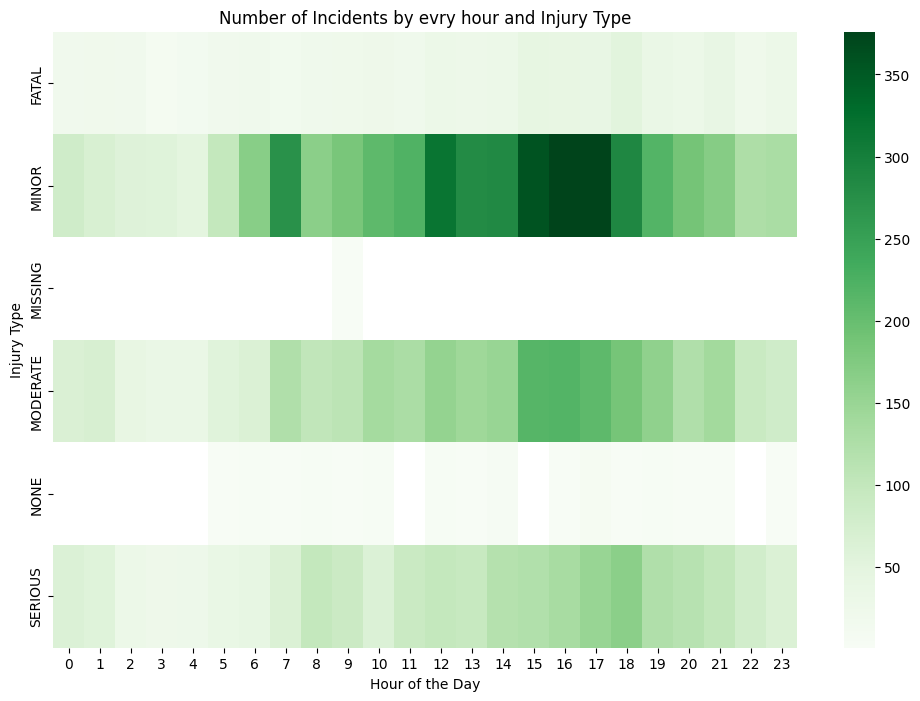

In [4]:
excel_file = pd.ExcelFile('Crash Information.xlsx')
df_time = pd.read_excel(excel_file, sheet_name='Sheet1', usecols=['Incident#', 'Time'])
df_injury = pd.read_excel(excel_file, sheet_name='Sheet3', usecols=['Incident#', 'Injury Type'])
merged_df = pd.merge(df_time, df_injury, on='Incident#')
merged_df['Time'] = pd.to_datetime(merged_df['Time'])
merged_df['Hour'] = merged_df['Time'].dt.hour
heatmap_df = merged_df.pivot_table(index='Injury Type', columns='Hour', values='Incident#', aggfunc='count')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap='Greens')
plt.title('Number of Incidents by evry hour and Injury Type')
plt.xlabel('Hour of the Day')
plt.ylabel('Injury Type')
plt.show()


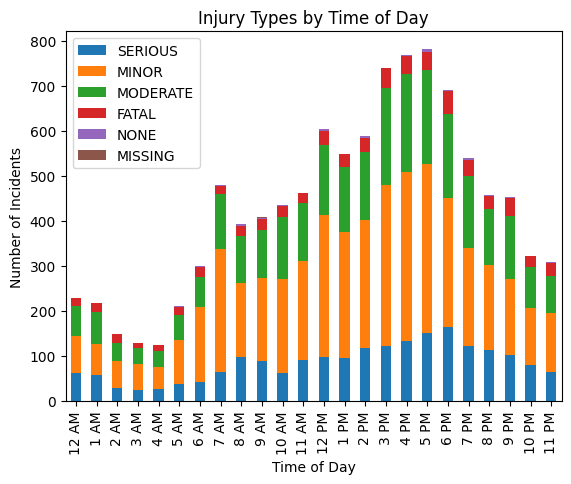

In [5]:
excel_file = pd.ExcelFile('Crash Information.xlsx')
df_time = pd.read_excel(excel_file, sheet_name='Sheet1', usecols=['Incident#', 'Time'])
df_injury = pd.read_excel(excel_file, sheet_name='Sheet3', usecols=['Incident#', 'Injury Type'])

# Merge the two dataframes based on 'Incident'
merged_df = pd.merge(df_time, df_injury, on='Incident#')

# Convert time strings to datetime objects
merged_df['Time'] = pd.to_datetime(merged_df['Time'], format='%I:%M%p')

# Create a new dataframe to hold the injury type counts for each hour
hourly_counts = pd.DataFrame(index=range(0, 24), columns=df_injury['Injury Type'].unique()).fillna(0)

for index, row in merged_df.iterrows():
    hour = row['Time'].hour
    injury_type = row['Injury Type']
    hourly_counts.at[hour, injury_type] += 1

# Plot the stacked bar chart
fig, ax = plt.subplots()
hourly_counts.plot(kind='bar', stacked=True, ax=ax)
hours = range(0, 24)
labels = []
for hour in hours:
    if hour == 0:
        labels.append('12 AM')
    elif hour < 12:
        labels.append(str(hour) + ' AM')
    elif hour == 12:
        labels.append('12 PM')
    else:
        labels.append(str(hour - 12) + ' PM')
ax.set_xticklabels(labels)

ax.set_xlabel('Time of Day')
ax.set_ylabel('Number of Incidents')
ax.set_title('Injury Types by Time of Day')
plt.show()


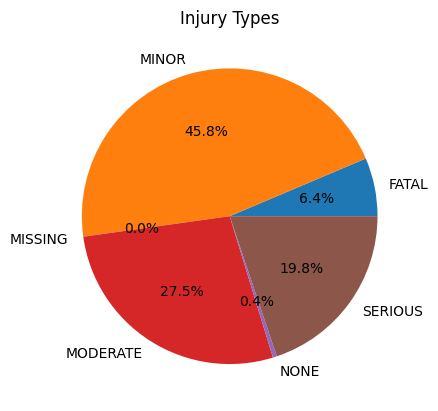

In [6]:
excel_file = pd.ExcelFile('Crash Information.xlsx')
df_time = pd.read_excel(excel_file, sheet_name='Sheet1', usecols=['Incident#', 'Time'])
df_injury = pd.read_excel(excel_file, sheet_name='Sheet3', usecols=['Incident#', 'Injury Type'])
merged_df = pd.merge(df_time, df_injury, on='Incident#')
injury_counts = merged_df.groupby('Injury Type').size()

# Create a pie chart of the injury types
injury_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Injury Types')
plt.ylabel('')
plt.show()


4. We understand the data of driver insurance in crash information by mapping them with injury type, display the major insurance companies involved in major and moderate injury types ---have to ski oe, UNK

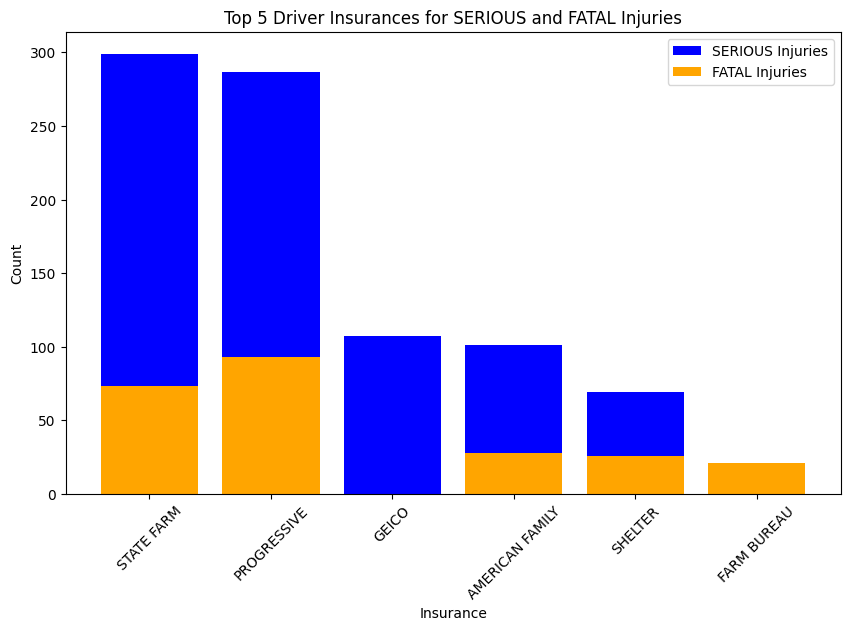

In [7]:
excel_file = pd.ExcelFile('Crash Information.xlsx')
df_insurance = pd.read_excel(excel_file, sheet_name='Sheet2', usecols=['Driver Insurance', 'Incident#'])
df_insurance = df_insurance[df_insurance['Driver Insurance'].isin(['UNKNOWN', 'NONE']) == False]
df_injury = pd.read_excel(excel_file, sheet_name='Sheet3', usecols=['Incident#','Injury Type'])
df_merged = pd.merge(df_insurance, df_injury, on='Incident#')
df_serious_injuries = df_merged[df_merged['Injury Type'] == 'SERIOUS']
df_fatal_injuries = df_merged[df_merged['Injury Type'] == 'FATAL']
INS_counts_serious = df_serious_injuries['Driver Insurance'].value_counts().head(5)
INS_counts_fatal = df_fatal_injuries['Driver Insurance'].value_counts().head(5)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(INS_counts_serious.index, INS_counts_serious.values, color='blue', label='SERIOUS Injuries')
ax.bar(INS_counts_fatal.index, INS_counts_fatal.values, color='orange', label='FATAL Injuries')
ax.set_xlabel('Insurance')
ax.set_ylabel('Count')
ax.set_title('Top 5 Driver Insurances for SERIOUS and FATAL Injuries')
ax.legend()
plt.xticks(rotation=45)
plt.show()

5. Get the data of top 20 counties where incidents take place using GPS co-ordinates and show them on real map

In [8]:
excel_file = pd.ExcelFile('Crash Information.xlsx')
df_time = pd.read_excel(excel_file, sheet_name='Sheet1')
df = df_time[['GPS Latitude', 'GPS Longitude', 'Incident#', 'County']]
incident_count = df.groupby(['GPS Latitude', 'GPS Longitude']).size().reset_index(name='Incident Count')
counties = df.groupby('County').size().reset_index(name='Incident Count').sort_values('Incident Count').tail(20)
# counties.to_excel('counties.xlsx', index=False)
# county_report = pd.ExcelFile('counties.xlsx')
print(counties)


           County  Incident Count
45         HOWELL              99
21      CHRISTIAN             102
104         STONE             105
52        LACLEDE             105
80         PHELPS             109
84        PULASKI             111
18           CASS             116
47        JACKSON             124
4           BARRY             129
48         JASPER             131
23           CLAY             133
106         TANEY             137
72         NEWTON             141
99   ST. FRANCOIS             148
50        JOHNSON             182
38         GREENE             210
35       FRANKLIN             275
49      JEFFERSON             307
97    ST. CHARLES             313
100     ST. LOUIS             384


In [9]:
excel_file = pd.ExcelFile('Crash Information.xlsx')
df_time = pd.read_excel(excel_file, sheet_name='Sheet1')
df = df_time[['GPS Latitude', 'GPS Longitude', 'Incident#', 'County']]
incident_count = df.groupby(['GPS Latitude', 'GPS Longitude']).size().reset_index(name='Incident Count')

# Create a heatmap of incident counts
map = folium.Map(location=[incident_count['GPS Latitude'].mean(), incident_count['GPS Longitude'].mean()], zoom_start=10)
heat_data = [[row['GPS Latitude'], row['GPS Longitude']] for index, row in incident_count.iterrows()]
plugins.HeatMap(heat_data, radius=10).add_to(map)
map.save('Accidents_heatmap.html')


# Lexical Analysis

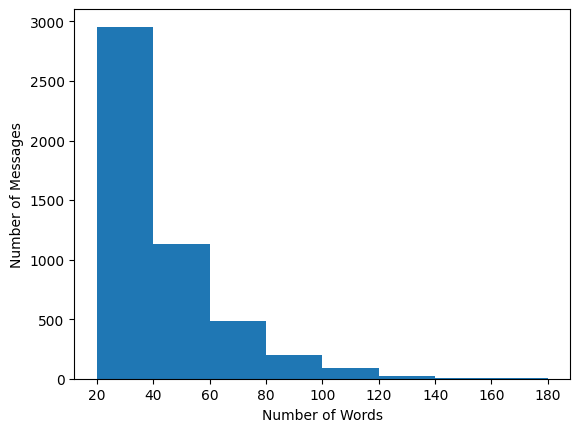

In [10]:
# Load your data as a pandas dataframe
df = pd.read_excel('Crash Information.xlsx', sheet_name='Sheet4')

def count_words(text):
    return len(text.split())
df['num_words'] = df['Misc Information'].apply(count_words)
intervals = range(20, max(df['num_words']), 20)
plt.hist(df['num_words'], bins=intervals)
plt.xlabel('Number of Words')
plt.ylabel('Number of Messages')
plt.show()

# Identifying the action and noun phrase verbs

Here we can identify the primary words involved in crash

In [11]:
# Read data from sheet 4 of the Excel file
df = pd.read_excel('Crash Information.xlsx', sheet_name='Sheet4')
text_column = df['Misc Information']
all_text = ' '.join(text_column)
all_text = re.sub(r'[^\w\s]', '', all_text).lower()
tokens = nltk.word_tokenize(all_text)
pos_tags = nltk.pos_tag(tokens)
verbal_phrases = []
for i in range(len(pos_tags)-1):
    if pos_tags[i][1].startswith('VB'): 
        phrase = pos_tags[i][0]
        j = i + 1
        while j < len(pos_tags) and not pos_tags[j][1].startswith('VB'): 
            if pos_tags[j][1].startswith('NN') or pos_tags[j][1].startswith('JJ'):
                phrase += ' ' + pos_tags[j][0]
            j += 1
        if j < len(pos_tags):
            phrase += ' ' + pos_tags[j][0]
        verbal_phrases.append(phrase)
phrase_counts = Counter(verbal_phrases)
top_phrases = phrase_counts.most_common(20)
for phrase, count in top_phrases:
    print(phrase, count)

was traveling 749
came rest 674
occurred vehicle was 425
failed yield 397
occurred vehicle ran 397
occurred vehicle travelled 389
failed negotiate 333
overturned assisted 321
was struck 295
overturned crash occurred 293
occurred vehicle traveled 291
occurred vehicle failed 277
occurred vehicle struck 265
was pronounced 242
was stopped 238
travelled right side roadway struck 237
traveled right side roadway struck 230
was travelling 217
ran right side roadway struck 201
occurred veh was 186


# Preprocessing the data for modelling to predict the injury type

In [12]:
excel_file = pd.ExcelFile('Crash Information.xlsx')
df1 = pd.read_excel(excel_file,sheet_name='Sheet3',usecols=['Injury Type', 'Incident#'])
df2 = pd.read_excel(excel_file, sheet_name='Sheet4', usecols=['Misc Information', 'Incident#'])
merged_df = pd.merge(df1, df2, on='Incident#')

# Display the 'number', 'name', and 'address' columns from the merged DataFrame
# print(merged_df[['Incident#','Injury Type','Misc Information']])

with pd.ExcelWriter('Learning_IT.xlsx') as writer:
    merged_df.to_excel(writer, index=False, sheet_name='Merged Data')

# Consolidating Misc Information and Injury Type on Incident# to train_test data

In [13]:
merged_data = pd.read_excel('Learning_IT.xlsx', sheet_name='Merged Data')
grouped_data = merged_data.groupby('Injury Type')
writer = pd.ExcelWriter('Learning_IT_Categories.xlsx', engine='xlsxwriter')
for name, group in grouped_data:
    group.to_excel(writer, sheet_name=name, index=False)

# Save the Excel file
writer.save()

<ipython-input-13-7960c2dc5603>:8: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


# Preprocessing of Misc Information data

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # convert text to lowercase
    text = text.lower()
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # tokenize text and remove stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    
    # lemmatize words
    words = [lemmatizer.lemmatize(w) for w in words]
    text = ' '.join(words)
    return text

# Separating the Injury_type categories for ease of training the data

In [15]:
data = {}

# read data from each sheet
for sheet in ['MODERATE', 'MINOR', 'SERIOUS', 'FATAL', 'NONE', 'MISSING']:
    sheet_data = pd.read_excel('Learning_IT_Categories.xlsx')
    sheet_data = sheet_data[['Misc Information', 'Injury Type']]
    
    # fill any missing values in 'Misc information' column with an empty string
    sheet_data['Misc Information'].fillna('', inplace=True)
    data[sheet] = sheet_data

# Implement Random Forest Classifier for modelling

In [16]:
data = pd.concat([
    pd.read_excel('Learning_IT_Categories.xlsx', sheet_name='MODERATE', usecols=['Misc Information', 'Injury Type']),
    pd.read_excel('Learning_IT_Categories.xlsx', sheet_name='MINOR', usecols=['Misc Information', 'Injury Type']),
    pd.read_excel('Learning_IT_Categories.xlsx', sheet_name='SERIOUS', usecols=['Misc Information', 'Injury Type']),
    pd.read_excel('Learning_IT_Categories.xlsx', sheet_name='FATAL', usecols=['Misc Information', 'Injury Type']),
    pd.read_excel('Learning_IT_Categories.xlsx', sheet_name='NONE', usecols=['Misc Information', 'Injury Type']),
], ignore_index=True)

data['Misc Information'].fillna('', inplace=True)

vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
classifier = RandomForestClassifier(n_estimators=100)

# train the classifier on the data
X = vectorizer.fit_transform(data['Misc Information'])
y = data['Injury Type']
classifier.fit(X, y)

RandomForestClassifier()

# Prediction 

In [17]:
# manually input a text message for testing
message = "***FATAL CRASH***NEXT OF KIN NOTIFIED*** TROOP A FATAL CRASH #23 AND FATALITY #25 FOR 2023."
# preprocess the message
message = pd.Series(message)
message = message.apply(preprocess_text)
# transform the message using the vectorizer
message_vectorized = vectorizer.transform(message)
# predict the injury type of the message
injury_type_predicted = classifier.predict(message_vectorized)
print("Predicted injury type:", injury_type_predicted)

Predicted injury type: ['FATAL']


# Modelling using various algorithms on Injury Type
*   Premilinary Analysis



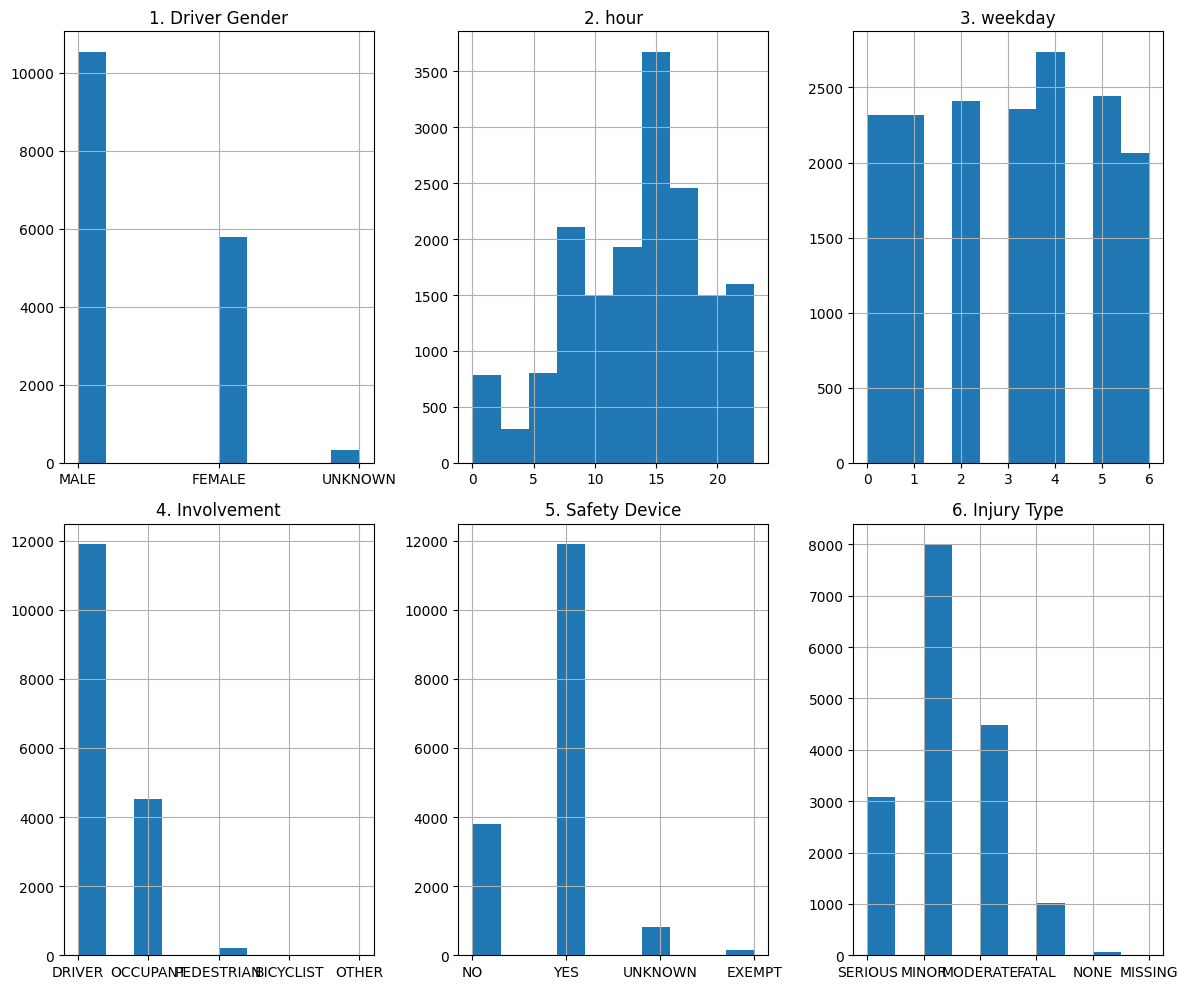

In [18]:
excel_file = pd.ExcelFile('Crash Information.xlsx')
df1 = pd.read_excel(excel_file, sheet_name='Sheet1', usecols=['Incident#', 'Date', 'Time', 'County'])
df2 = pd.read_excel(excel_file, sheet_name='Sheet2', usecols=['Incident#', 'Driver Gender', 'Driver Age', 'Safety Device', 'Driver City/State', 'Driver Insurance', 'Vehicle Description', 'Damage', 'Disposition'])
df3 = pd.read_excel(excel_file, sheet_name='Sheet3', usecols=['Incident#', 'Injury Type', 'Involvement'])
merged_df = pd.merge(df1, pd.merge(df2, df3, on='Incident#'), on='Incident#')

# Merge the fourth DataFrame with the merged DataFrame based on the 'Incident#' column
# merged_df = pd.merge(merged_df, on='Incident#')

# Print the resulting merged DataFrame
# print(merged_df)

#create weekday column
merged_df['newdate'] = pd.to_datetime(merged_df['Date']) #tell the computer that the 'Date' column is the date
merged_df['weekday'] = merged_df["newdate"].dt.weekday

# _create hour column
merged_df['newtime'] = pd.to_datetime(merged_df['Time']) #tell the computer that the 'Time' column 1s the time of the accident 
merged_df['hour'] = merged_df['newtime'].dt.hour

features = ['Incident#', 'Safety Device', 'Involvement', 'Driver Gender', 'Driver Age' , 'weekday', 'hour', 'County', 'Driver City/State', 'Driver Insurance','Vehicle Description', 'Damage', 'Disposition']
target = 'Injury Type'

#plot
n_rows= 2
n_cols = 3
fig, axs = plt.subplots(n_rows,n_cols,figsize=(12,10))
i = 0
for ind, col in enumerate(['Driver Gender', 'hour', 'weekday', 'Involvement', 'Safety Device', 'Injury Type']):
    merged_df[col].hist(ax=axs[int(i / n_cols),i % n_cols])
    axs[int(i/ n_cols),i % n_cols].set_title(str(i+1)+ '. '+col)
    i = i  + 1
plt.tight_layout()
plt.show()



# Multinomial Naive-Bayes Classifiction






In [19]:
#convert categorical variable to dummy variables 
merged_df = pd.get_dummies(merged_df, columns=features)
new_features = [c for c in merged_df.columns.values if c.split("_")[0] in features]

X = merged_df[new_features]
y = merged_df[target]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1)

model =  MultinomialNB()
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Performance
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.5723723723723724
[[   1   81    0   54    0   60]
 [   0 1380    0  208    0   70]
 [   0    1    0    0    0    0]
 [   1  438    0  333    0   89]
 [   0    8    0    5    0    1]
 [   0  268    0  140    0  192]]
              precision    recall  f1-score   support

       FATAL       0.50      0.01      0.01       196
       MINOR       0.63      0.83      0.72      1658
     MISSING       0.00      0.00      0.00         1
    MODERATE       0.45      0.39      0.42       861
        NONE       0.00      0.00      0.00        14
     SERIOUS       0.47      0.32      0.38       600

    accuracy                           0.57      3330
   macro avg       0.34      0.26      0.25      3330
weighted avg       0.55      0.57      0.53      3330



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# K-Nearest Neighbors (KNN) Classification


In [20]:
KNC_model = KNeighborsClassifier()
KNC_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = KNC_model.predict(X_test)

# Evaluate the model
accuracy = KNC_model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Performance
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.5531531531531532
[[  61   61    0   32    0   42]
 [  56 1273    0  239    1   89]
 [   0    1    0    0    0    0]
 [  36  416    0  330    0   79]
 [   0    7    0    4    2    1]
 [  55  245    0  124    0  176]]
              precision    recall  f1-score   support

       FATAL       0.29      0.31      0.30       196
       MINOR       0.64      0.77      0.70      1658
     MISSING       0.00      0.00      0.00         1
    MODERATE       0.45      0.38      0.42       861
        NONE       0.67      0.14      0.24        14
     SERIOUS       0.45      0.29      0.36       600

    accuracy                           0.55      3330
   macro avg       0.42      0.32      0.33      3330
weighted avg       0.54      0.55      0.54      3330



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree Classification

In [21]:
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = tree_model.predict(X_test)

# Evaluate the model
accuracy = tree_model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Performance
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))


Accuracy: 0.4837837837837838
[[  36   56    0   43    0   61]
 [  44 1144    0  300    1  169]
 [   0    1    0    0    0    0]
 [  39  434    0  260    4  124]
 [   1    4    0    4    3    2]
 [  63  236    0  128    5  168]]
              precision    recall  f1-score   support

       FATAL       0.20      0.18      0.19       196
       MINOR       0.61      0.69      0.65      1658
     MISSING       0.00      0.00      0.00         1
    MODERATE       0.35      0.30      0.33       861
        NONE       0.23      0.21      0.22        14
     SERIOUS       0.32      0.28      0.30       600

    accuracy                           0.48      3330
   macro avg       0.29      0.28      0.28      3330
weighted avg       0.47      0.48      0.47      3330



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest Classification

In [22]:
RFC_model = RandomForestClassifier()
RFC_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = RFC_model.predict(X_test)

# Evaluate the model
accuracy = RFC_model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Performance
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.5378378378378378
[[  24   84    0   27    0   61]
 [  23 1417    0  142    2   74]
 [   0    1    0    0    0    0]
 [  14  569    0  171    0  107]
 [   0    8    0    3    2    1]
 [  32  302    0   86    3  177]]
              precision    recall  f1-score   support

       FATAL       0.26      0.12      0.17       196
       MINOR       0.60      0.85      0.70      1658
     MISSING       0.00      0.00      0.00         1
    MODERATE       0.40      0.20      0.27       861
        NONE       0.29      0.14      0.19        14
     SERIOUS       0.42      0.29      0.35       600

    accuracy                           0.54      3330
   macro avg       0.33      0.27      0.28      3330
weighted avg       0.49      0.54      0.49      3330



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Neural Network Model - Multi-layer Perceptron Classifier

In [23]:
MLP_model = MLPClassifier()
MLP_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = MLP_model.predict(X_test)

# Evaluate the model
accuracy = MLP_model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Performance
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.6075075075075075
[[  51   58    0   28    0   59]
 [  34 1266    0  221    1  136]
 [   0    1    0    0    0    0]
 [  18  276    0  433    2  132]
 [   0    4    0    4    3    3]
 [  34  169    0  124    3  270]]
              precision    recall  f1-score   support

       FATAL       0.37      0.26      0.31       196
       MINOR       0.71      0.76      0.74      1658
     MISSING       0.00      0.00      0.00         1
    MODERATE       0.53      0.50      0.52       861
        NONE       0.33      0.21      0.26        14
     SERIOUS       0.45      0.45      0.45       600

    accuracy                           0.61      3330
   macro avg       0.40      0.37      0.38      3330
weighted avg       0.60      0.61      0.60      3330



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
print(y_pred)

['MINOR' 'MINOR' 'MINOR' ... 'MINOR' 'MINOR' 'FATAL']
